In [1]:
import torch
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights

from lightly.models.modules import BarlowTwinsProjectionHead

In [2]:
class Tempo50(nn.Module):
    def __init__(self, state_dict):
        super(Tempo50, self).__init__()
        self.backbone: nn. Module = resnet50()
        missing, unexpected = self.backbone.load_state_dict(state_dict)
        self.backbone.fc = nn.Identity()
        # TODO: add assert for loading state dict
        self.projection_head = BarlowTwinsProjectionHead(
            input_dim=2048,
            hidden_dim=2048,
            output_dim=2048
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.projection_head(x)
        return x

In [3]:
imagenet_1k_state_dict = ResNet50_Weights.IMAGENET1K_V1.get_state_dict(True)

## Train Tempo

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import transforms as T
from lightly.loss import BarlowTwinsLoss

from tempo.data.datasets import video_dataset50, finetune_dataset50

In [5]:
# Use GPU if availabel
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}.')

Using device: cuda.


In [6]:
model = Tempo50(imagenet_1k_state_dict).to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.79 GiB total capacity; 47.78 MiB already allocated; 37.62 MiB free; 58.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    losses = []
    for image, image_d, _, _ in tqdm(dataloader):
        image = image.to(device)
        image_d = image_d.to(device)
        
        z0 = model(image)
        z1 = model(image_d)
        loss = criterion(z0, z1)
        losses.append(loss.detach())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    avg_loss = torch.tensor(losses).mean()
    return avg_loss

In [ ]:
# Load datasets
train_loader = video_dataset50(proximity=15, batch_size=20)
train_loader_ft = finetune_dataset50(name='ASL-big', train=True, batch_size=20)
test_loader_ft = finetune_dataset50(train=False, batch_size=20)

50
50
50


In [ ]:
criterion = BarlowTwinsLoss(lambda_param=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(50):
    loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(epoch, loss)

100%|██████████| 188/188 [01:17<00:00,  2.41it/s]


0 tensor(611.1765)


100%|██████████| 188/188 [01:15<00:00,  2.50it/s]


1 tensor(524.1909)


100%|██████████| 188/188 [01:16<00:00,  2.47it/s]


2 tensor(478.5904)


100%|██████████| 188/188 [01:14<00:00,  2.53it/s]


3 tensor(447.1273)


100%|██████████| 188/188 [01:14<00:00,  2.53it/s]


4 tensor(432.0645)


100%|██████████| 188/188 [01:16<00:00,  2.45it/s]


5 tensor(390.3020)


100%|██████████| 188/188 [01:17<00:00,  2.42it/s]


6 tensor(377.2551)


100%|██████████| 188/188 [01:15<00:00,  2.49it/s]


7 tensor(376.5053)


100%|██████████| 188/188 [01:17<00:00,  2.43it/s]


8 tensor(359.6029)


100%|██████████| 188/188 [01:17<00:00,  2.44it/s]


9 tensor(350.5522)


100%|██████████| 188/188 [01:16<00:00,  2.45it/s]


10 tensor(348.5835)


100%|██████████| 188/188 [01:17<00:00,  2.44it/s]


11 tensor(339.6612)


100%|██████████| 188/188 [01:16<00:00,  2.47it/s]


12 tensor(347.5157)


100%|██████████| 188/188 [01:15<00:00,  2.48it/s]


13 tensor(336.3514)


100%|██████████| 188/188 [01:15<00:00,  2.50it/s]


14 tensor(329.3310)


100%|██████████| 188/188 [01:16<00:00,  2.47it/s]


15 tensor(321.2737)


100%|██████████| 188/188 [01:15<00:00,  2.48it/s]


16 tensor(327.5622)


100%|██████████| 188/188 [01:16<00:00,  2.46it/s]


17 tensor(328.2325)


100%|██████████| 188/188 [01:15<00:00,  2.51it/s]


18 tensor(322.6911)


100%|██████████| 188/188 [01:15<00:00,  2.49it/s]


19 tensor(326.3767)


100%|██████████| 188/188 [01:14<00:00,  2.53it/s]


20 tensor(320.7519)


100%|██████████| 188/188 [01:16<00:00,  2.46it/s]


21 tensor(320.3700)


100%|██████████| 188/188 [01:16<00:00,  2.46it/s]


22 tensor(326.5123)


100%|██████████| 188/188 [01:16<00:00,  2.45it/s]


23 tensor(313.6443)


100%|██████████| 188/188 [01:17<00:00,  2.43it/s]


24 tensor(308.8745)


100%|██████████| 188/188 [01:16<00:00,  2.45it/s]


25 tensor(313.6443)


100%|██████████| 188/188 [01:15<00:00,  2.50it/s]


26 tensor(311.1138)


100%|██████████| 188/188 [01:14<00:00,  2.52it/s]


27 tensor(316.9085)


100%|██████████| 188/188 [01:15<00:00,  2.48it/s]


28 tensor(308.1811)


100%|██████████| 188/188 [01:17<00:00,  2.42it/s]


29 tensor(311.0280)


100%|██████████| 188/188 [01:17<00:00,  2.44it/s]


30 tensor(311.1156)


100%|██████████| 188/188 [01:15<00:00,  2.48it/s]


31 tensor(312.4390)


100%|██████████| 188/188 [01:17<00:00,  2.44it/s]


32 tensor(301.5800)


100%|██████████| 188/188 [01:15<00:00,  2.50it/s]


33 tensor(304.5230)


100%|██████████| 188/188 [01:14<00:00,  2.52it/s]


34 tensor(299.1825)


100%|██████████| 188/188 [01:16<00:00,  2.45it/s]


35 tensor(301.0342)


100%|██████████| 188/188 [01:17<00:00,  2.41it/s]


36 tensor(298.3828)


100%|██████████| 188/188 [01:15<00:00,  2.48it/s]


37 tensor(301.3936)


100%|██████████| 188/188 [01:16<00:00,  2.46it/s]


38 tensor(296.4002)


100%|██████████| 188/188 [01:16<00:00,  2.45it/s]


39 tensor(308.7345)


100%|██████████| 188/188 [01:17<00:00,  2.44it/s]


40 tensor(303.4328)


100%|██████████| 188/188 [01:17<00:00,  2.43it/s]


41 tensor(301.1194)


100%|██████████| 188/188 [01:20<00:00,  2.34it/s]


42 tensor(295.9100)


100%|██████████| 188/188 [01:15<00:00,  2.50it/s]


43 tensor(294.9180)


100%|██████████| 188/188 [01:14<00:00,  2.51it/s]


44 tensor(297.2253)


100%|██████████| 188/188 [01:15<00:00,  2.49it/s]


45 tensor(301.0965)


100%|██████████| 188/188 [01:15<00:00,  2.49it/s]


46 tensor(292.9469)


100%|██████████| 188/188 [01:14<00:00,  2.52it/s]


47 tensor(294.4779)


100%|██████████| 188/188 [01:16<00:00,  2.45it/s]


48 tensor(293.5894)


100%|██████████| 188/188 [01:16<00:00,  2.46it/s]

49 tensor(291.3064)


## Linear Eval

In [ ]:
model.backbone.fc

Identity()

In [ ]:
def test_model_fast(model, test_reps, test_dataset, device):

    model.eval()

    wrongly_classified = 0
    for repr, label in test_reps:
        total = repr.shape[0]

        inputs, labels = repr.to(device), label.to(device)

        with torch.no_grad():
            preds = model(inputs).argmax(dim=1)

        wrong = (total - (preds == labels).sum()).item()
        wrongly_classified += wrong

    model.train()

    return 1.0 - (wrongly_classified / len(test_dataset))

In [ ]:
def linear_eval_new(iterations, model, train_loader, test_loader, device):

    reps = []
    test_reps = []
    with torch.no_grad():
        for input, label in train_loader:
            repr = model(input.to(device)).detach()
            repr = torch.flatten(repr, start_dim=1)
            reps.append((repr, label.to(device)))

        for input, label in test_loader:
            repr = model(input.to(device)).detach()
            repr = torch.flatten(repr, start_dim=1)
            test_reps.append((repr, label.to(device)))

    model.fc = nn.Linear(in_features=2048, out_features=24, bias=True).to(
    device)  # Fresh detection head

    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, weight_decay=0.0001)

    losses, errors, iters_ = [], [], []
    i = 0
    every = 1
    running_loss = 0.0
    b1 = False
    while True:
        for repr, label in reps:
            if i % every == 0:
                test_error = test_model_fast(model.fc, test_reps, test_loader.dataset, device)
                losses.append(running_loss)
                errors.append(test_error)
                iters_.append(i)
                running_loss = 0

                if i == iterations:
                    b1=True
                    break

            labels = nn.functional.one_hot(label, num_classes=24).float()
            inputs, labels = repr.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model.fc(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            i += 1

        if i == iterations and b1:
            break
    losses, errors, iters_ = np.array(losses), np.array(errors), np.array(iters_)

    return (losses, errors, iters_)

In [ ]:
losses, errors, iters = linear_eval_new(3_000, model.backbone, train_loader_ft, test_loader_ft, device)

0.5916666666666667

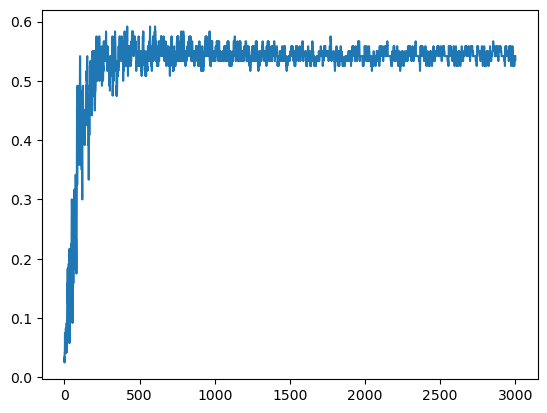

In [ ]:
plt.plot(errors)
errors.max()

In [ ]:
torch.save(model.backbone.state_dict(), 'model_zoo/tempoXX.pth')